In [36]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

In [19]:
df_sbi = web.DataReader("SETFNIFBK.NS","yahoo","2019-10-1","2020-10-15")["Adj Close"]
df_bankbees = web.DataReader("KOTAKBKETF.NS","yahoo","2019-10-1","2020-10-15")["Adj Close"]

In [20]:
df_bankbees.tail()

Date
2020-10-09    240.179993
2020-10-12    238.720001
2020-10-13    236.740005
2020-10-14    240.460007
2020-10-15    232.500000
Name: Adj Close, dtype: float64

In [50]:
df = web.DataReader("KOTAKBKETF.NS","yahoo","2019-10-1","2020-10-15")

In [51]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [23]:
df_sbi.tail()

Date
2020-10-09    237.279999
2020-10-12    235.850006
2020-10-13    234.029999
2020-10-14    237.509995
2020-10-15    229.899994
Name: Adj Close, dtype: float64

In [21]:
df = pd.concat([df_sbi, df_bankbees],axis=1)
df.columns =["SBI","KOTAK"]

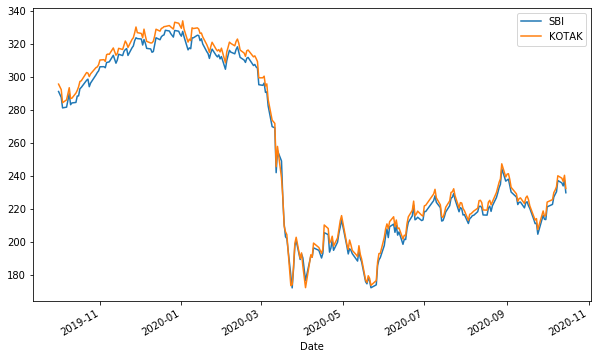

In [22]:
df.plot(figsize=(10,6))

In [26]:
from statsmodels.api import OLS

In [27]:
model = OLS(df["SBI"][:90], df["KOTAK"][:90])

In [28]:
res = model.fit()

In [29]:
res.params

KOTAK    0.985794
dtype: float64

In [30]:
df["spread"] = df["SBI"]- res.params[0]*df["KOTAK"]

In [31]:
df.spread

Date
2019-10-01   -0.279393
2019-10-03   -0.566547
2019-10-04    0.890779
2019-10-07   -0.335041
2019-10-09    0.619661
                ...   
2020-10-09    0.511924
2020-10-12    0.521183
2020-10-13    0.653044
2020-10-14    0.465884
2020-10-15    0.702813
Name: spread, Length: 253, dtype: float64

In [32]:
from statsmodels.tsa.stattools import adfuller
# Compute ADF test statistics
adf = adfuller(df.spread,maxlag=1)
adf[0]

-7.463854752613066

In [33]:
adf

(-7.463854752613066,
 5.2672497666217674e-11,
 1,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 869.6661794282202)

In [37]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

In [45]:
df = stat_arb(df,107,1)

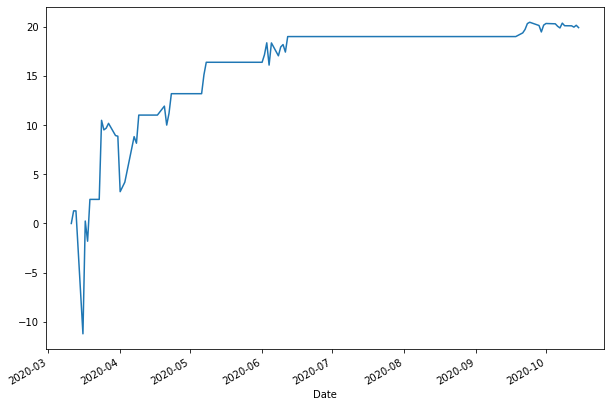

In [47]:
df.cumpnl.plot(label='PnL', figsize=(10,7))  
# plt.xlabel('Date')  
# plt.ylabel('Cumulative Pnl')  
# plt.show()
df.to_csv("C:/Users/Priyanka/OneDrive/Documents/stat_Arb1.csv")